In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


In [2]:
import os
import zipfile

extract_path = "/kaggle/working/plates_dataset"
zip_path = "/kaggle/input/platesv2/plates.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted successfully!")

Files extracted successfully!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.io import read_image
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix

In [4]:
torch.manual_seed(42)
transform_width = 164

# basic_transforms = transforms.Compose([
#     transforms.CenterCrop(256),
#     transforms.Resize((transform_width, transform_width)),
#     transforms.ToTensor(),
# ])
basic_transforms = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Resize((transform_width, transform_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

dataset = ImageFolder(
    os.path.join(extract_path, 'plates', 'train'),
    transform=basic_transforms,
)
n = len(dataset)
train_size = int(.8 * n)
test_size = n - train_size

dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)
dataloader_test = DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=1,
)

Image Size: torch.Size([1, 3, 164, 164]), Label: 0


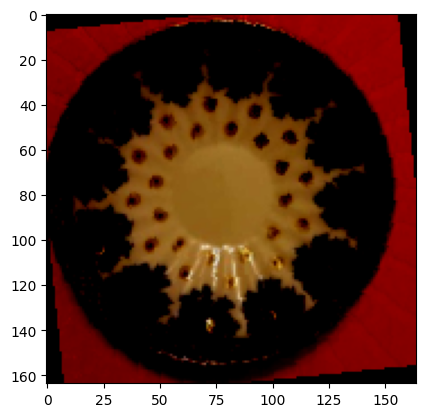

In [5]:
image, label = next(iter(dataloader_train))
print(f"Image Size: {image.shape}, Label: {label.item()}")

image = image.squeeze().permute(1, 2, 0)
plt.imshow(image)
plt.show()

In [6]:
class CleanDirtyAnalyzer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(

            # First Batch
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(.5),

            # Second Batch
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.2),
            nn.Flatten(),
        )
        self.fc = nn.Linear(
            64 * transform_width // 4 * transform_width // 4, 
            num_classes,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CleanDirtyAnalyzer(num_classes=2)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
num_epochs = 15

model.train()
for epoch in range(num_epochs):
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss}")
    

Epoch: 1/15, Loss: 3.754375457763672
Epoch: 2/15, Loss: 0.7720507383346558
Epoch: 3/15, Loss: 0.030509103089571
Epoch: 4/15, Loss: 1.1589304208755493
Epoch: 5/15, Loss: 0.18455547094345093
Epoch: 6/15, Loss: 0.017452361062169075
Epoch: 7/15, Loss: 0.08080931752920151
Epoch: 8/15, Loss: 0.9984840154647827
Epoch: 9/15, Loss: 0.0066322204656898975
Epoch: 10/15, Loss: 0.05081666633486748
Epoch: 11/15, Loss: 0.5651547312736511
Epoch: 12/15, Loss: 2.3841855067985307e-07
Epoch: 13/15, Loss: 0.48762646317481995
Epoch: 14/15, Loss: 0.0007010624394752085
Epoch: 15/15, Loss: 0.004666272550821304


In [8]:
accuracy = BinaryAccuracy()
confusion_matrix = BinaryConfusionMatrix()

model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        accuracy(preds, labels)
        confusion_matrix(preds, labels)

score = accuracy.compute()
print(f"Accuracy: {score}")

matrix = confusion_matrix.compute()
matrix

Accuracy: 0.375


tensor([[2, 0],
        [5, 1]])

In [9]:
from PIL import Image
pd.read_csv('/kaggle/input/platesv2/sample_submission.csv').head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [10]:
rev_map = {idx: label for label, idx in dataset.class_to_idx.items()}

In [11]:
base_path = os.path.join(extract_path, 'plates', 'test')
ids = []
images = []

for file in os.listdir(base_path):
    if file.endswith('jpg'):
        fileId = int(file[:file.index('.')])
        ids.append(fileId)
        
        image = Image.open(os.path.join(base_path, file))
        image = basic_transforms(image)
        images.append(image)

In [12]:
class TestDataset(Dataset):
    def __init__(self, images, ids):
        self.images = images
        self.ids = ids
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.ids[idx]

test_dataset = TestDataset(images, ids)
test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=1,
)

In [13]:
submission = []

model.eval()
with torch.no_grad():
    for images, ID in test_dataloader:
        outputs = model(images)
        pred = torch.argmax(outputs, 1)
        submission.append({
            'id': ID.item(),
            'label': rev_map[pred.item()],
        })

In [14]:
submission = pd.DataFrame(submission) \
    .sort_values(by='id') \
    .reset_index().drop('index', axis=1)

submission.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head()

,id,label
0,0,cleaned
1,1,cleaned
2,2,cleaned
3,3,cleaned
4,4,cleaned


In [15]:
import shutil
shutil.rmtree(extract_path)